# Darksky Cleaner

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
from scipy import stats
import scipy
import math
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime

import seaborn as sns
# sns.set()
sns.set_style('whitegrid')
sns.set_context("poster")

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
day_labels = ['MON','TUE','WED','THU','FRI','SAT','SUN']
day_labels_full = ['MONDAY','TUESDAY','WEDNESDAY','THURSDAY','FRIDAY','SATURDAY','SUNDAY']
month_labels = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']

ordered_zipcodes = [94107, 95113, 94041, 94301, 94063]

# Load Weather Data

In [4]:
print('Started Loading Weather Data...')
file_path_slug = '../source_data/darksky/*.csv'
file_list = glob(file_path_slug)

weather_df = pd.DataFrame()

num_files = len(file_list)
chunks = []

for i, file in enumerate(file_list):

    chunk = pd.read_csv(file, index_col=0, parse_dates=['time_corrected'])

    chunks.append(chunk)
    
    if (i + 1) == 1 or (i + 1) % math.ceil(num_files/10) == 0 or (i + 1) == num_files:
        print('\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), str(i+1).rjust(8), str(num_files).rjust(8)))

    
weather_df = pd.concat(chunks)
print('Data Loaded Successfully!')

Started Loading Weather Data...
	[19:22:57.337447] finished chunk        1 of    66114
	[19:23:34.598767] finished chunk     6612 of    66114
	[19:24:07.613746] finished chunk    13224 of    66114
	[19:24:48.811781] finished chunk    19836 of    66114
	[19:25:21.483217] finished chunk    26448 of    66114
	[19:26:01.205937] finished chunk    33060 of    66114
	[19:26:42.504443] finished chunk    39672 of    66114
	[19:27:21.505143] finished chunk    46284 of    66114
	[19:28:03.430907] finished chunk    52896 of    66114
	[19:28:43.115199] finished chunk    59508 of    66114
	[19:29:24.519081] finished chunk    66114 of    66114
Data Loaded Successfully!


In [5]:
weather = weather_df.copy()

## Prune Columns

In [6]:
drop_cols = ['offset', 'time']

for dc in drop_cols:
    try:
        weather.drop(dc, axis=1, inplace=True)
    except:
        pass

weather.drop_duplicates(inplace=True)
weather.reset_index(inplace=True, drop=True)

## Encode 'precipType'
<ul>
    <li>rain -> 1</li>
    <li>nan -> 0</li>
</ul>

In [7]:
weather.precipType.fillna(0, inplace=True)
weather.precipType = weather.precipType.apply(lambda x: 0 if x == 0 else 1)

# Merge Station Data
<p>append `station_id` and `zip_code`</p>

In [8]:
def zip_to_landmark(zip_code):
    ''' Return zipcode for given landmark'''
    if zip_code == 94107:
        return 'San Francisco'
    if zip_code == 94063:
        return 'Redwood City'
    if zip_code == 94301:
        return 'Palo Alto'
    if zip_code == 94041:
        return 'Mountain View'
    if zip_code == 95113:
        return 'San Jose'
    return False

In [9]:
stations = pd.read_csv('../clean_data/bayareabikeshare/station_data_cleaned.csv', index_col=0)
stations.head()

station_id                               name        lat        long  \
0           2  San Jose Diridon Caltrain Station  37.329732 -121.901782   
1           3              San Jose Civic Center  37.330698 -121.888979   
2           4             Santa Clara at Almaden  37.333988 -121.894902   
3           5                   Adobe on Almaden  37.331415 -121.893200   
4           6                   San Pedro Square  37.336721 -121.894074   

   dock_count  landmark first_service_date last_service_date  zip_code  \
0          27  San Jose         2013-08-29        2016-08-31     95113   
1          15  San Jose         2013-08-29        2016-08-31     95113   
2          11  San Jose         2013-08-29        2016-08-31     95113   
3          19  San Jose         2013-08-29        2016-08-31     95113   
4          15  San Jose         2013-08-29        2016-08-31     95113   

   days_in_service  
0             1098  
1             1098  
2             1098  
3             1098  
4             1098

In [10]:
# set float precision
stations['lat']  = stations['lat'].map(lambda x: '%2.6f' % x)
stations['long'] = stations['long'].map(lambda x: '%2.6f' % x)

# set float precision
weather['latitude']  = weather['latitude'].map(lambda x: '%2.6f' % x)
weather['longitude'] = weather['longitude'].map(lambda x: '%2.6f' % x)

In [11]:
weather.head(3)

apparentTemperature  cloudCover daily_icon  \
0                53.93        0.31       rain   
1                54.72         NaN       rain   
2                53.94         NaN       rain   

                                       daily_summary  dewPoint  \
0  Heavy rain starting overnight, continuing unti...     50.44   
1  Heavy rain starting overnight, continuing unti...     50.83   
2  Heavy rain starting overnight, continuing unti...     50.07   

           hourly_icon hourly_summary  humidity   latitude    longitude  \
0  partly-cloudy-night  Partly Cloudy      0.88  37.795392  -122.394203   
1          clear-night          Clear      0.87  37.795392  -122.394203   
2          clear-night          Clear      0.87  37.795392  -122.394203   

   precipIntensity  precipProbability  precipType  pressure  temperature  \
0           0.0059               0.59           1   1012.43        53.93   
1           0.0059               0.59           1   1012.13        54.72   
2           0.0112               0.85           1   1012.32        53.94   

       time_corrected  visibility  windBearing  windSpeed  
0 2014-12-16 00:00:00        9.29        131.0      10.26  
1 2014-12-16 01:00:00        8.41        146.0       8.84  
2 2014-12-16 02:00:00        8.11        149.0       8.02

In [12]:
stations.head(3)

station_id                               name        lat         long  \
0           2  San Jose Diridon Caltrain Station  37.329732  -121.901782   
1           3              San Jose Civic Center  37.330698  -121.888979   
2           4             Santa Clara at Almaden  37.333988  -121.894902   

   dock_count  landmark first_service_date last_service_date  zip_code  \
0          27  San Jose         2013-08-29        2016-08-31     95113   
1          15  San Jose         2013-08-29        2016-08-31     95113   
2          11  San Jose         2013-08-29        2016-08-31     95113   

   days_in_service  
0             1098  
1             1098  
2             1098

In [13]:
weather_merged = weather.merge(stations, left_on=['latitude', 'longitude'], right_on=['lat', 'long'])

drop_cols = ['name', 'lat', 'long', 'dock_count', 'first_service_date', 'last_service_date', 'days_in_service']

for dc in drop_cols:
    try:
        weather_merged.drop(dc, axis=1, inplace=True)
    except:
        pass

weather_merged.head(3)

apparentTemperature  cloudCover daily_icon  \
0                53.93        0.31       rain   
1                54.72         NaN       rain   
2                53.94         NaN       rain   

                                       daily_summary  dewPoint  \
0  Heavy rain starting overnight, continuing unti...     50.44   
1  Heavy rain starting overnight, continuing unti...     50.83   
2  Heavy rain starting overnight, continuing unti...     50.07   

           hourly_icon hourly_summary  humidity   latitude    longitude  \
0  partly-cloudy-night  Partly Cloudy      0.88  37.795392  -122.394203   
1          clear-night          Clear      0.87  37.795392  -122.394203   
2          clear-night          Clear      0.87  37.795392  -122.394203   

     ...     precipType  pressure  temperature      time_corrected  \
0    ...              1   1012.43        53.93 2014-12-16 00:00:00   
1    ...              1   1012.13        54.72 2014-12-16 01:00:00   
2    ...              1   1012.32        53.94 2014-12-16 02:00:00   

   visibility windBearing  windSpeed  station_id       landmark  zip_code  
0        9.29       131.0      10.26          50  San Francisco     94107  
1        8.41       146.0       8.84          50  San Francisco     94107  
2        8.11       149.0       8.02          50  San Francisco     94107  

[3 rows x 22 columns]

In [14]:
weather_merged.describe()

apparentTemperature    cloudCover      dewPoint      humidity  \
count         1.586743e+06  1.363580e+06  1.586743e+06  1.586743e+06   
mean          5.926332e+01  1.512079e-01  4.948934e+01  7.186864e-01   
std           7.598377e+00  1.818528e-01  6.731419e+00  1.550477e-01   
min           2.589000e+01  0.000000e+00  7.270000e+00  1.200000e-01   
25%           5.462000e+01  0.000000e+00  4.631000e+01  6.200000e-01   
50%           5.882000e+01  1.200000e-01  5.042000e+01  7.500000e-01   
75%           6.340000e+01  2.400000e-01  5.435000e+01  8.400000e-01   
max           9.661000e+01  1.000000e+00  6.560000e+01  1.000000e+00   

       precipIntensity  precipProbability    precipType      pressure  \
count     1.586743e+06       1.586743e+06  1.586743e+06  1.586743e+06   
mean      1.299324e-03       2.583651e-02  5.566749e-02  1.016222e+03   
std       1.098214e-02       1.329410e-01  2.292786e-01  4.596603e+00   
min       0.000000e+00       0.000000e+00  0.000000e+00  9.936100e+02   
25%       0.000000e+00       0.000000e+00  0.000000e+00  1.013060e+03   
50%       0.000000e+00       0.000000e+00  0.000000e+00  1.015750e+03   
75%       0.000000e+00       0.000000e+00  0.000000e+00  1.019190e+03   
max       6.281000e-01       1.000000e+00  1.000000e+00  1.031960e+03   

        temperature    visibility   windBearing     windSpeed    station_id  \
count  1.586743e+06  1.586743e+06  1.586186e+06  1.586314e+06  1.586743e+06   
mean   5.936134e+01  9.153926e+00  2.411017e+02  5.830687e+00  4.553355e+01   
std    7.391343e+00  1.152798e+00  8.541428e+01  3.604809e+00  2.359421e+01   
min    2.978000e+01  2.300000e-01  0.000000e+00  0.000000e+00  2.000000e+00   
25%    5.462000e+01  8.890000e+00  2.050000e+02  3.030000e+00  2.800000e+01   
50%    5.882000e+01  9.530000e+00  2.630000e+02  5.260000e+00  4.900000e+01   
75%    6.339000e+01  9.880000e+00  3.030000e+02  7.950000e+00  6.600000e+01   
max    9.661000e+01  1.000000e+01  3.590000e+02  4.071000e+01  9.100000e+01   

           zip_code  
count  1.586743e+06  
mean   9.431503e+04  
std    4.087736e+02  
min    9.404100e+04  
25%    9.410700e+04  
50%    9.410700e+04  
75%    9.430100e+04  
max    9.511300e+04

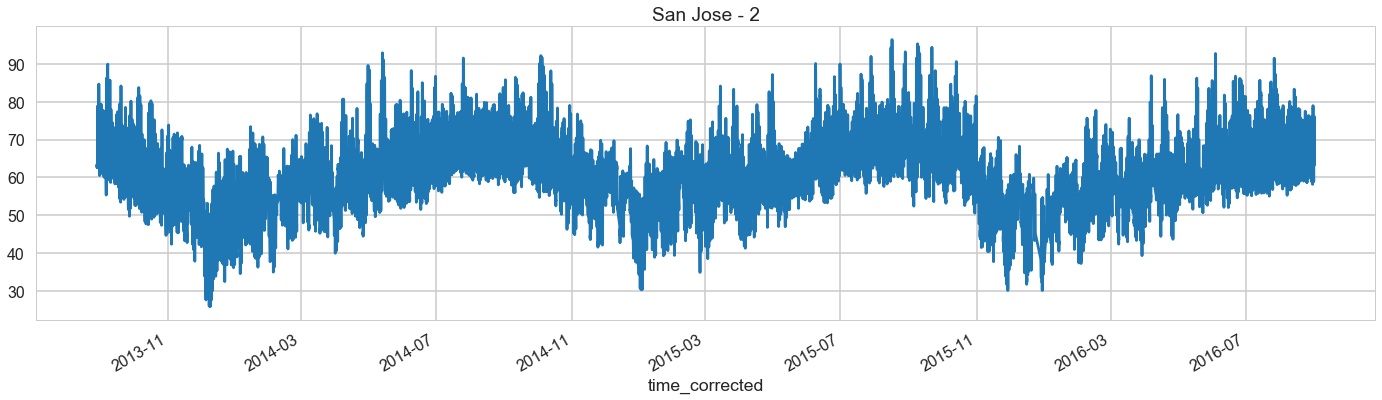

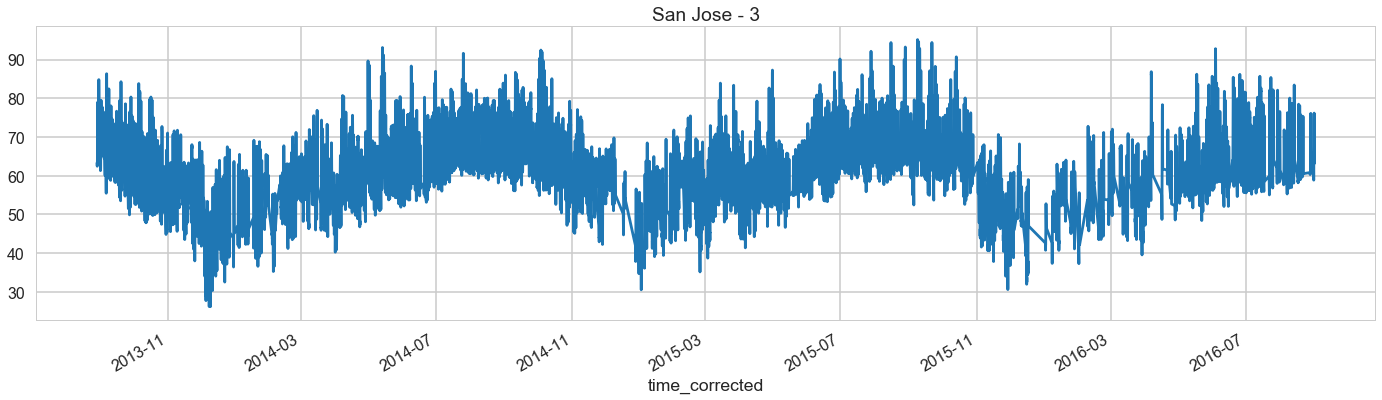

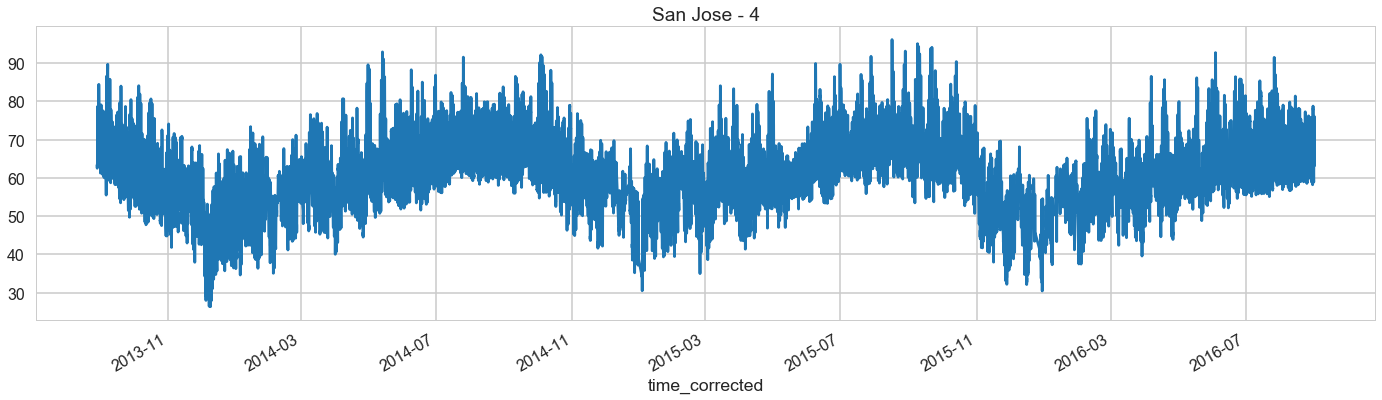

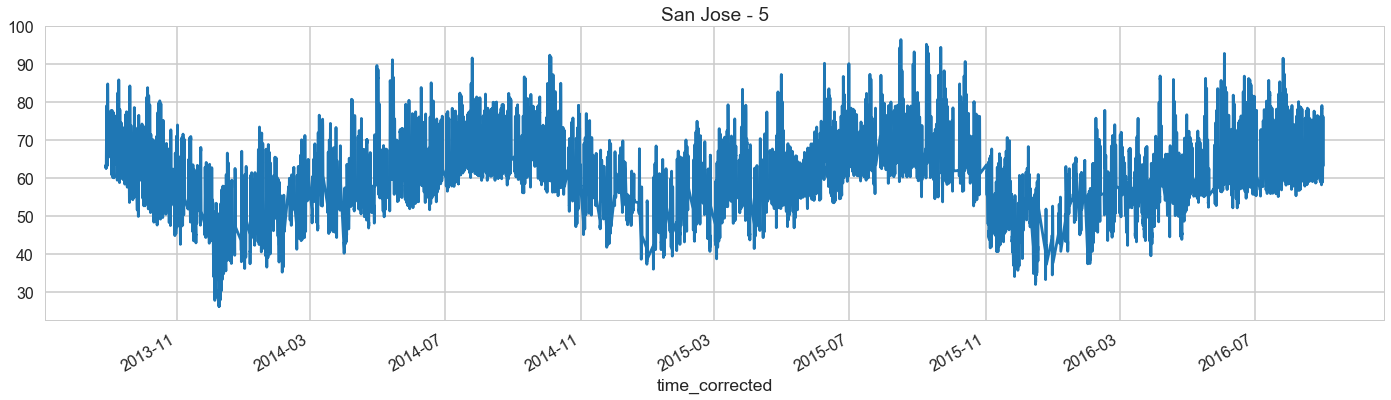

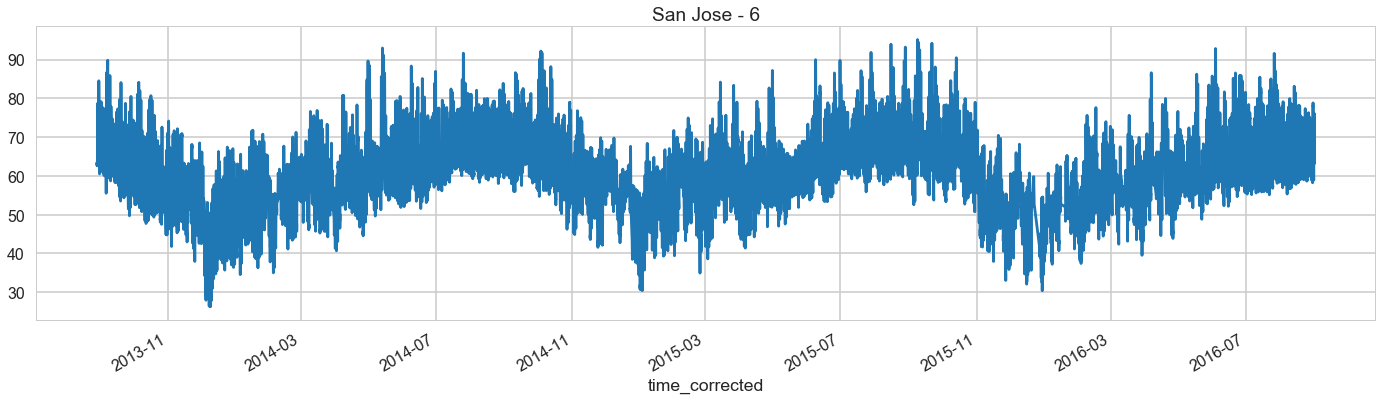

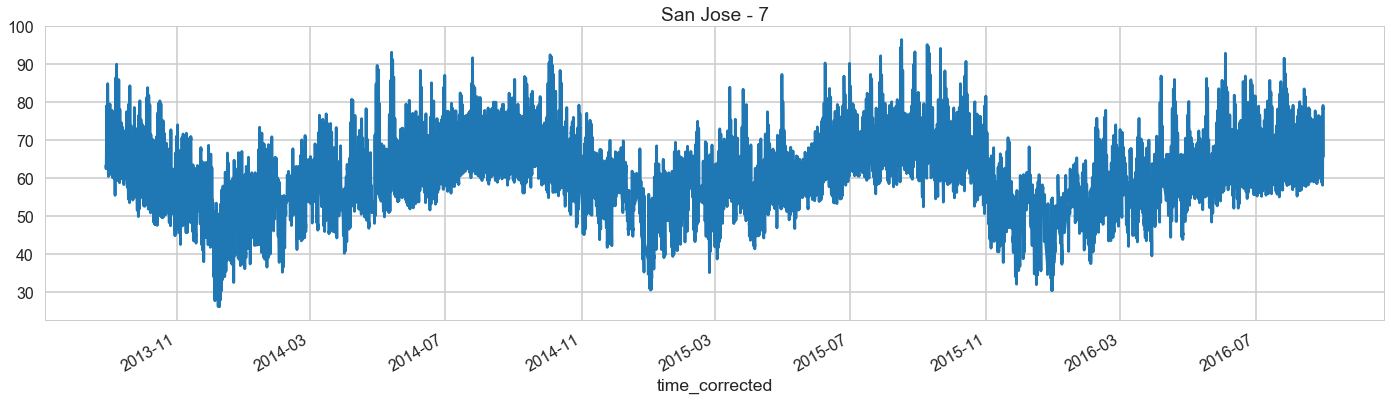

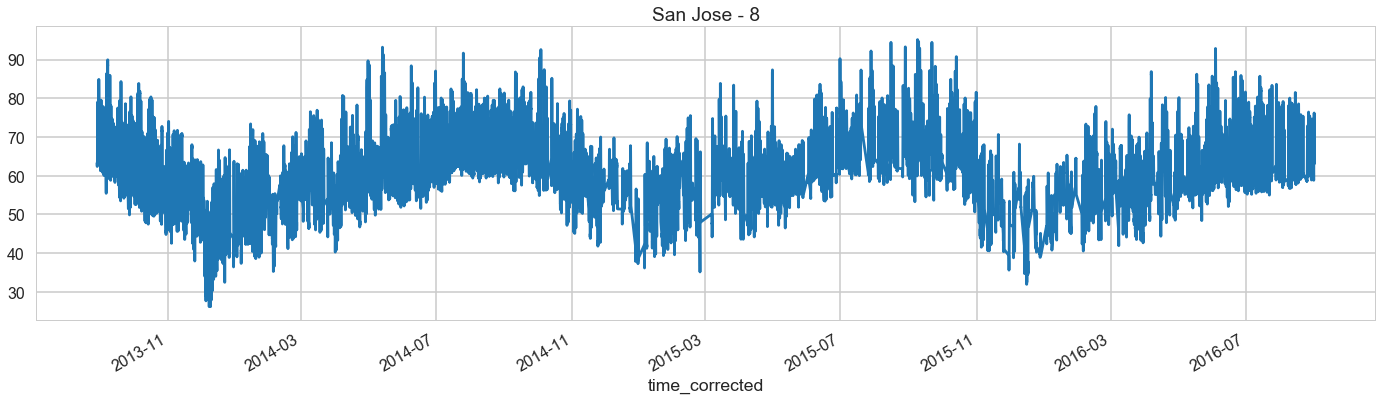

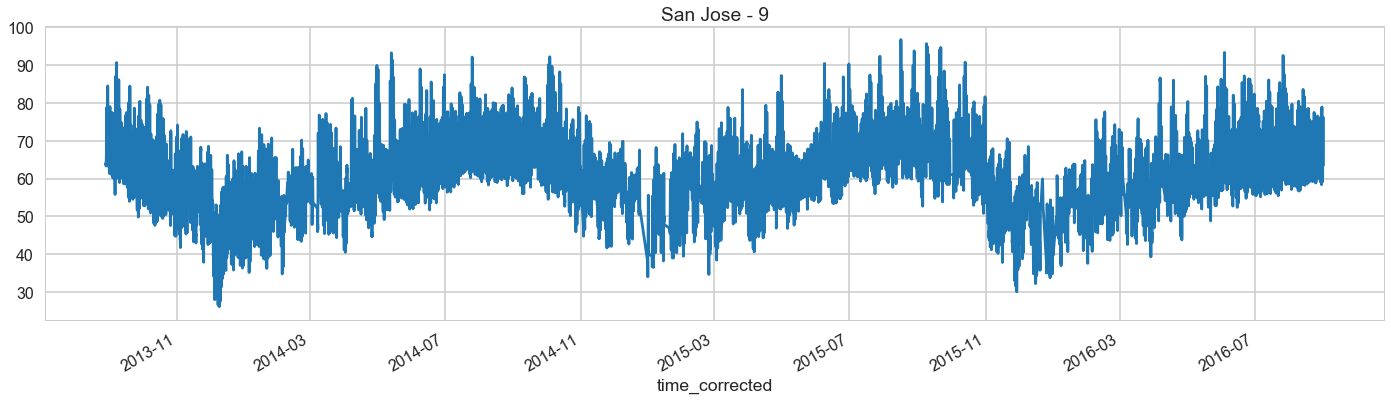

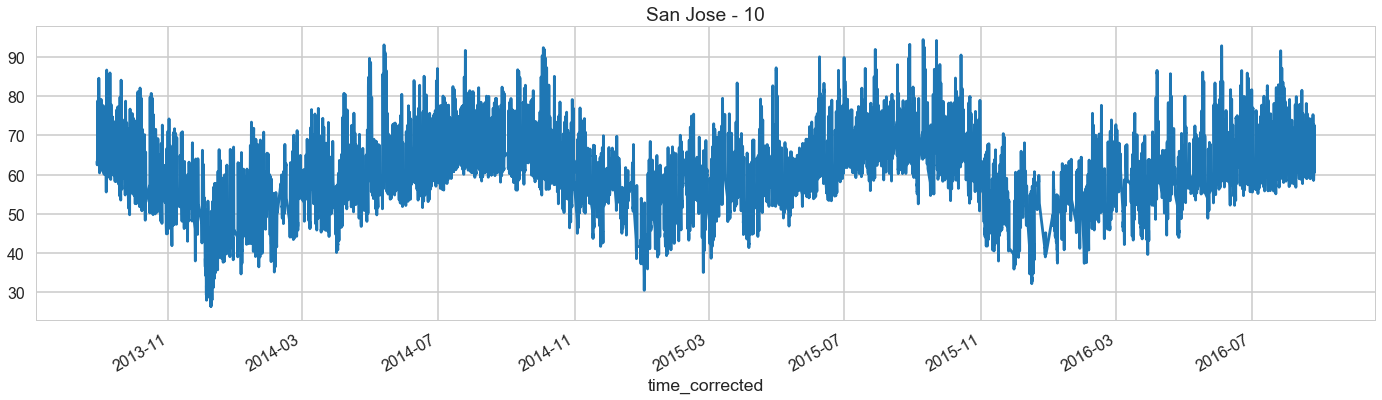

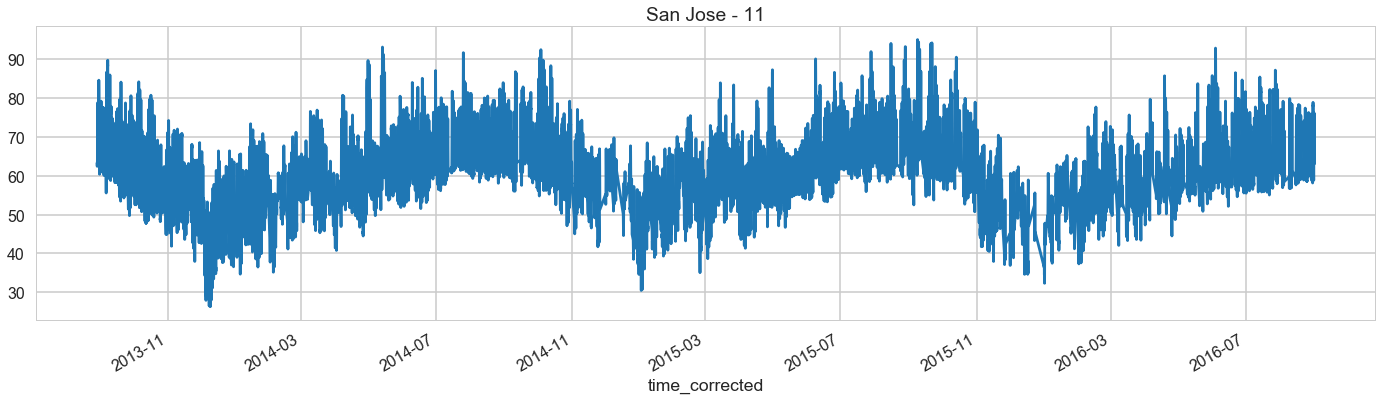

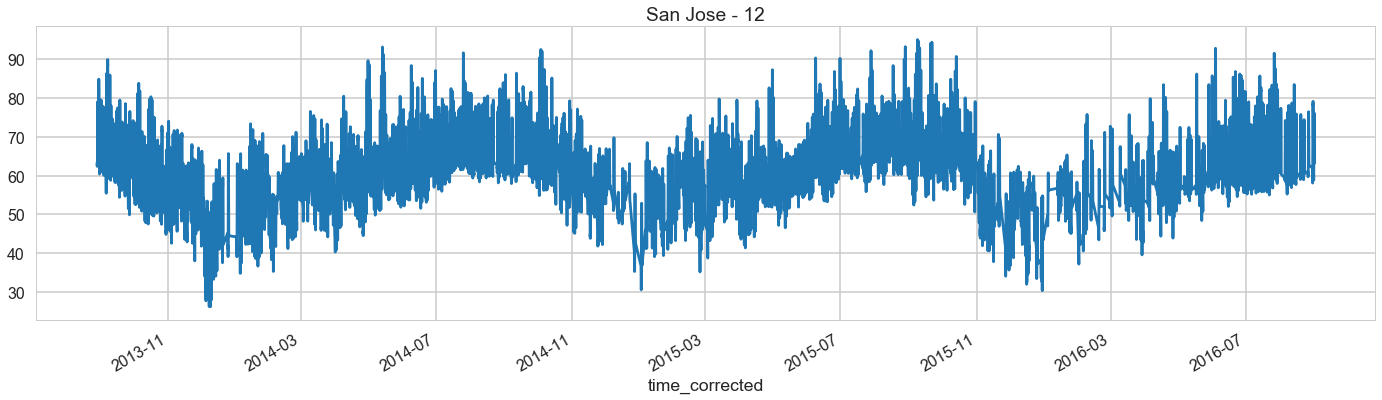

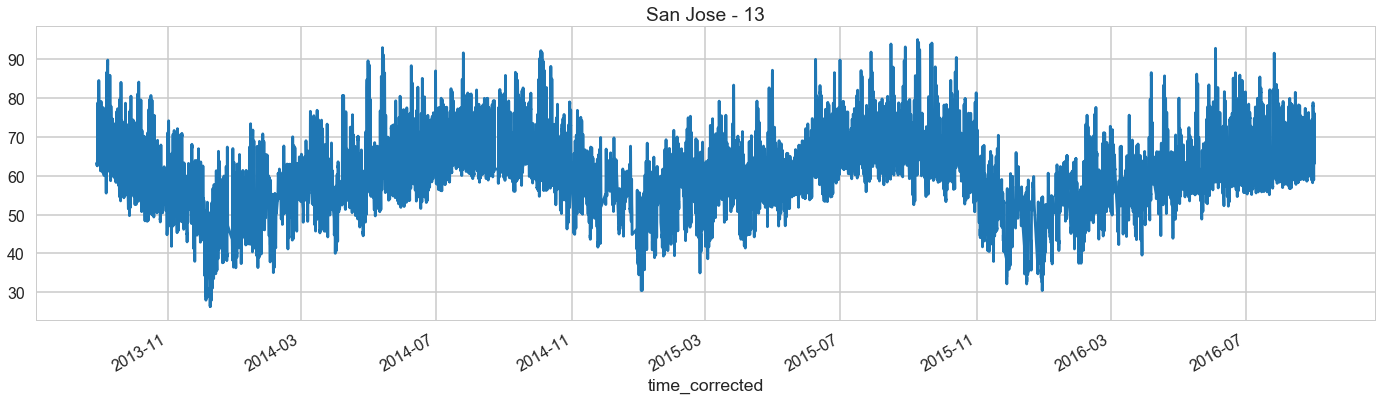

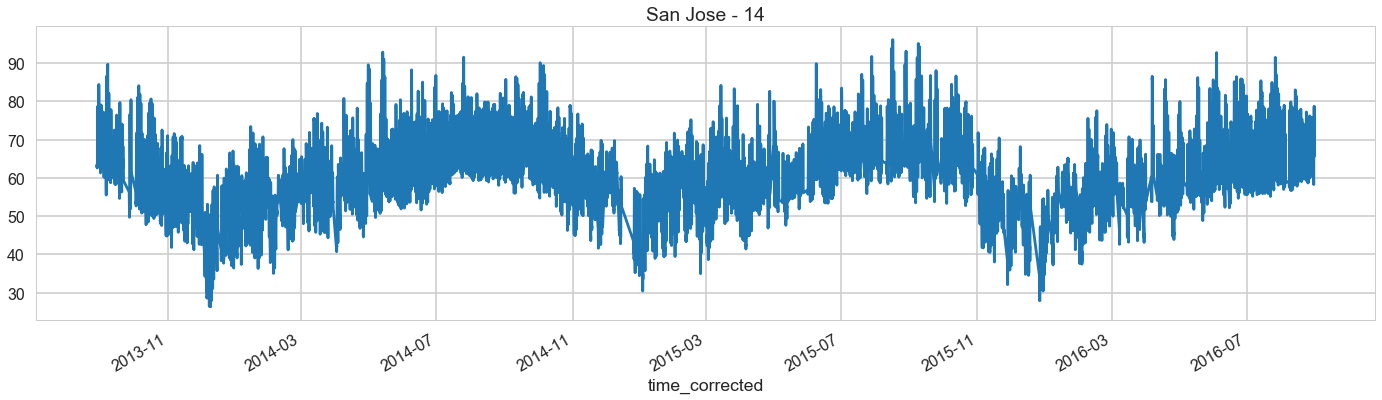

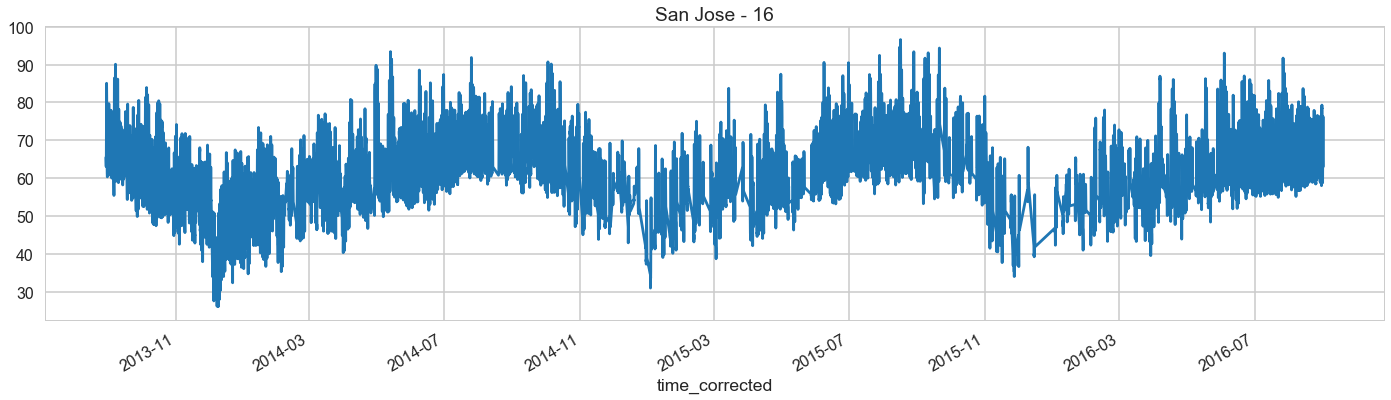

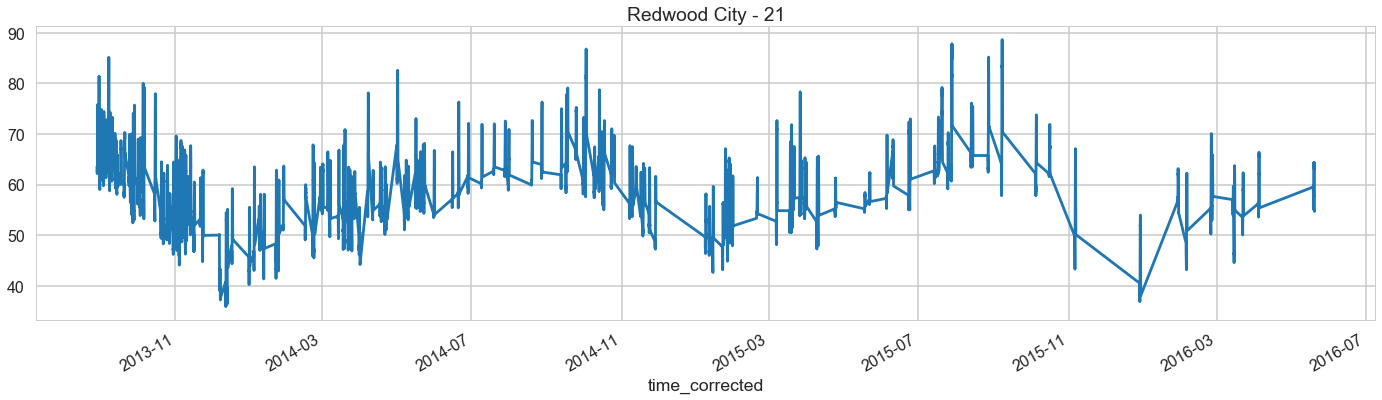

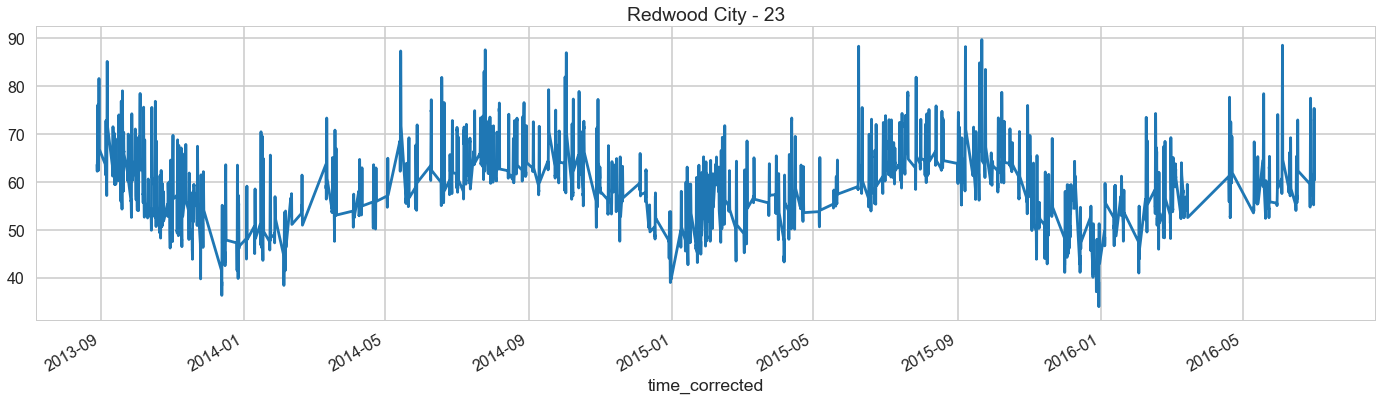

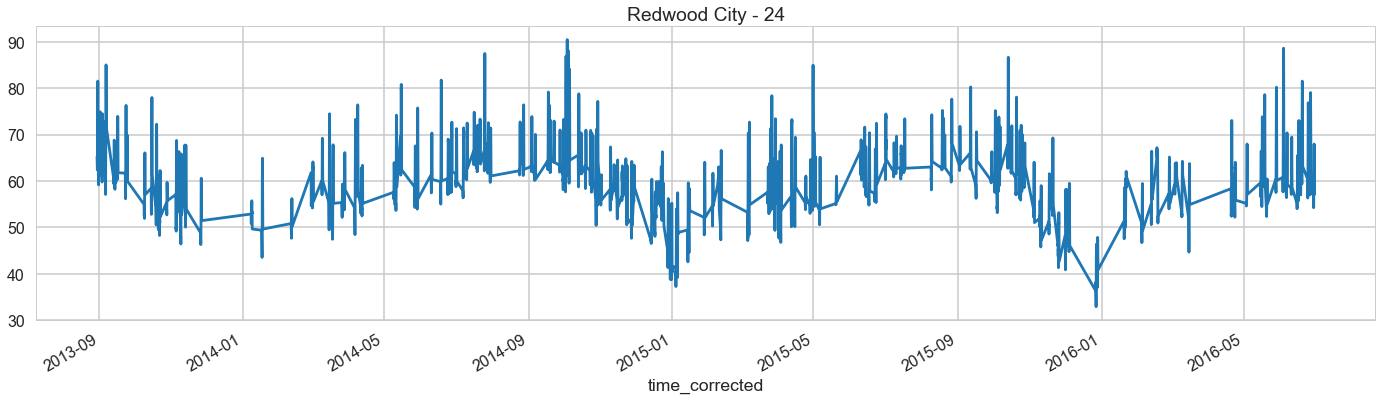

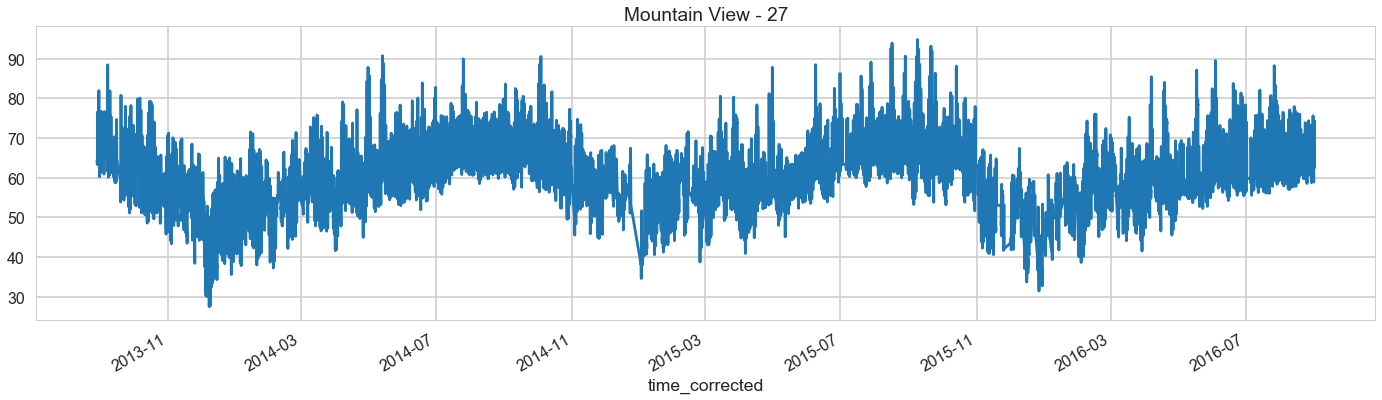

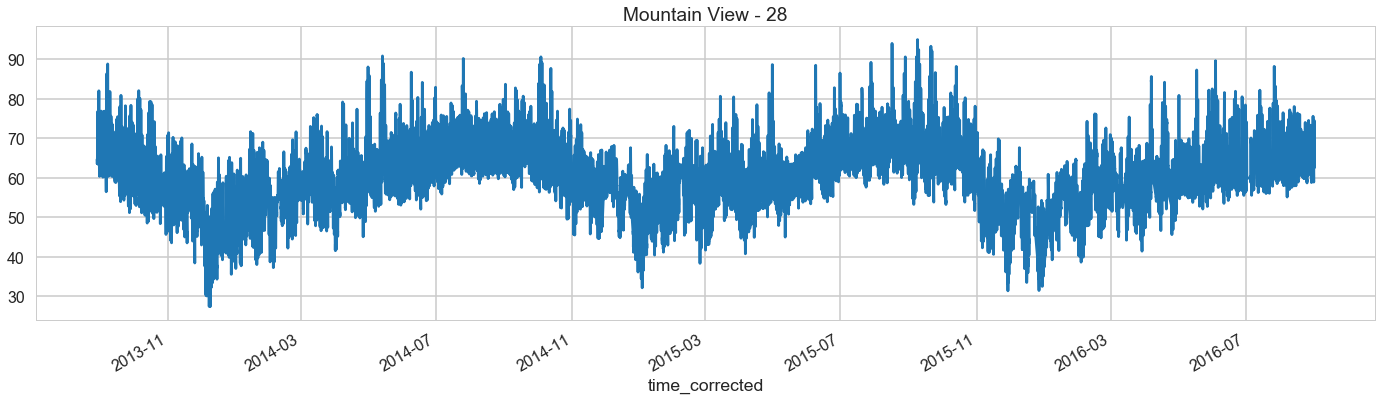

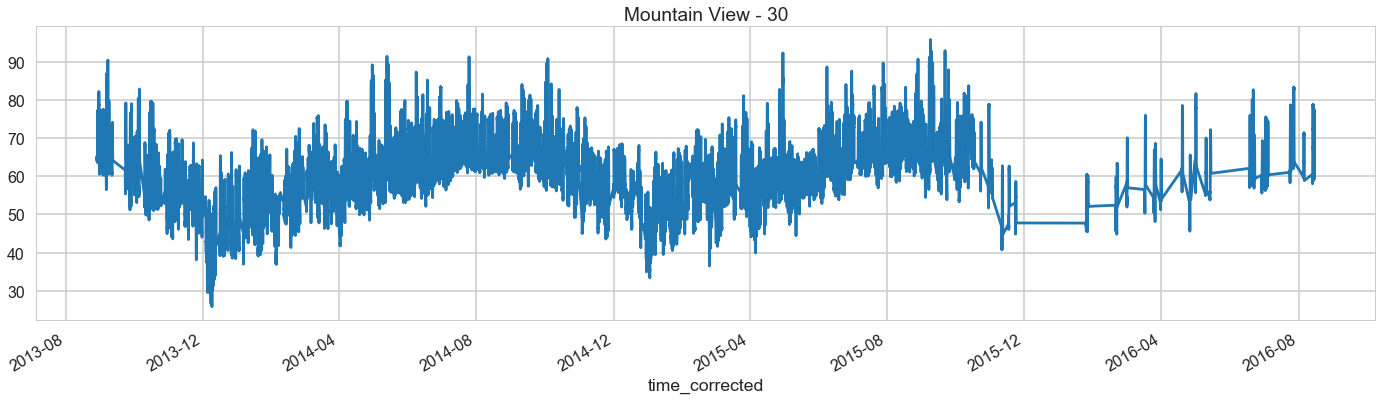

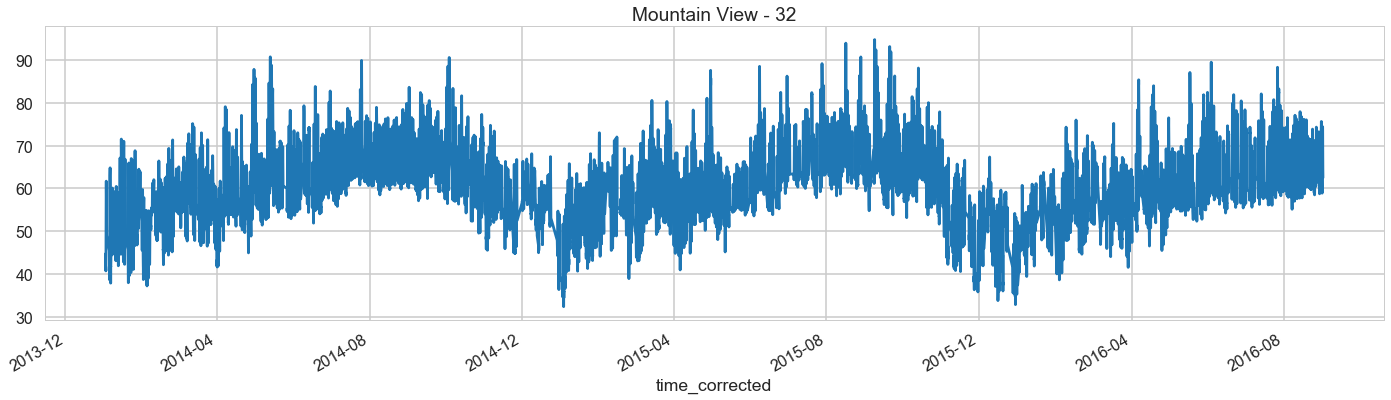

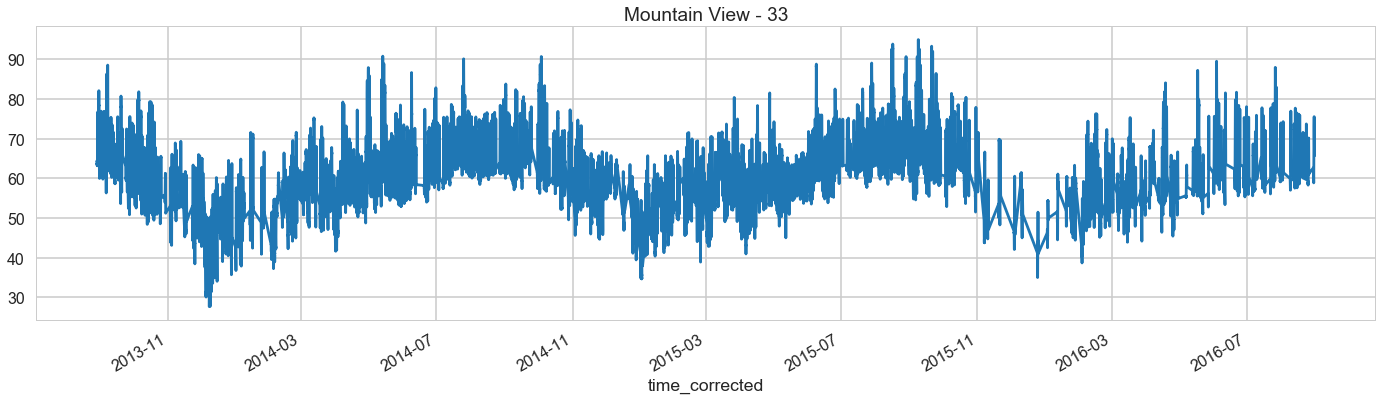

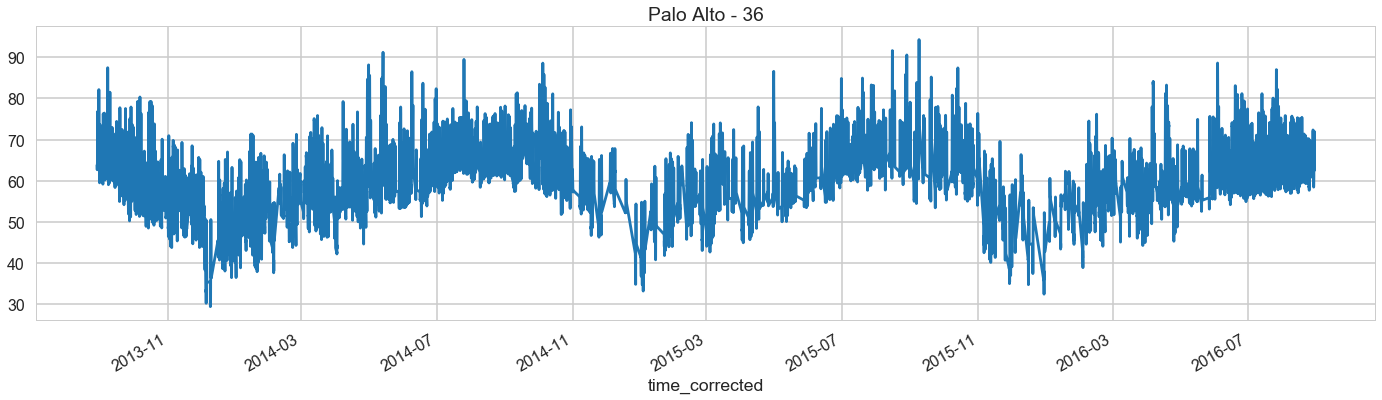

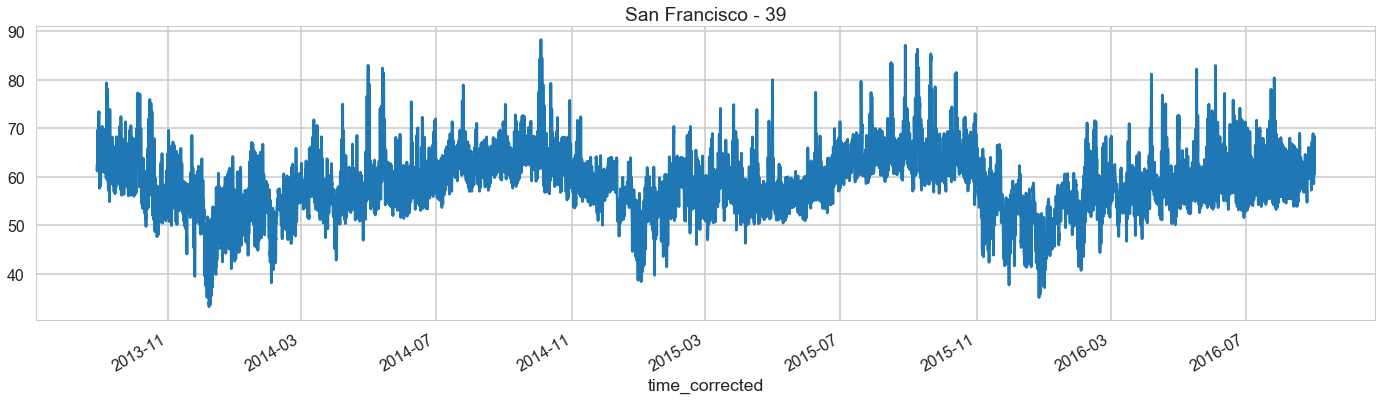

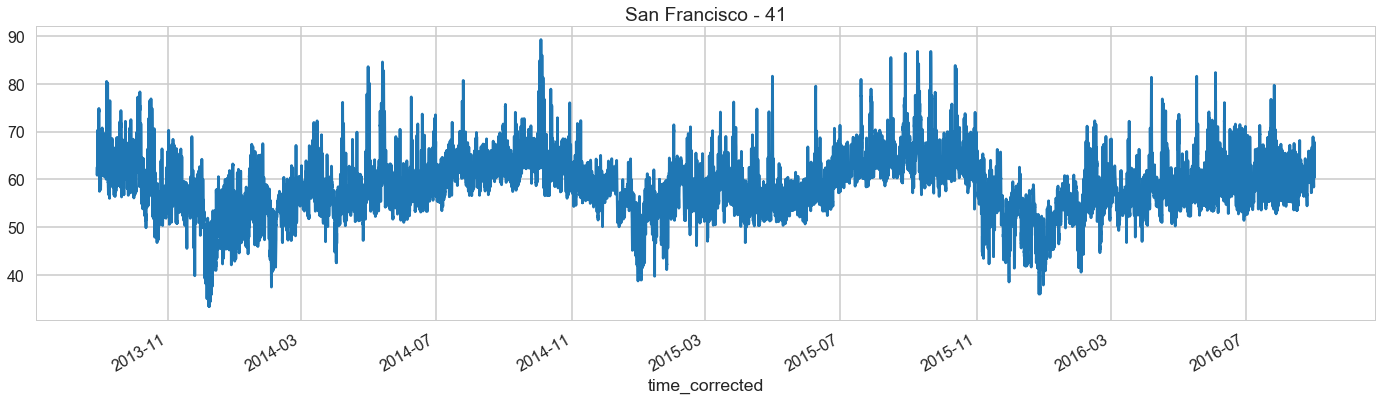

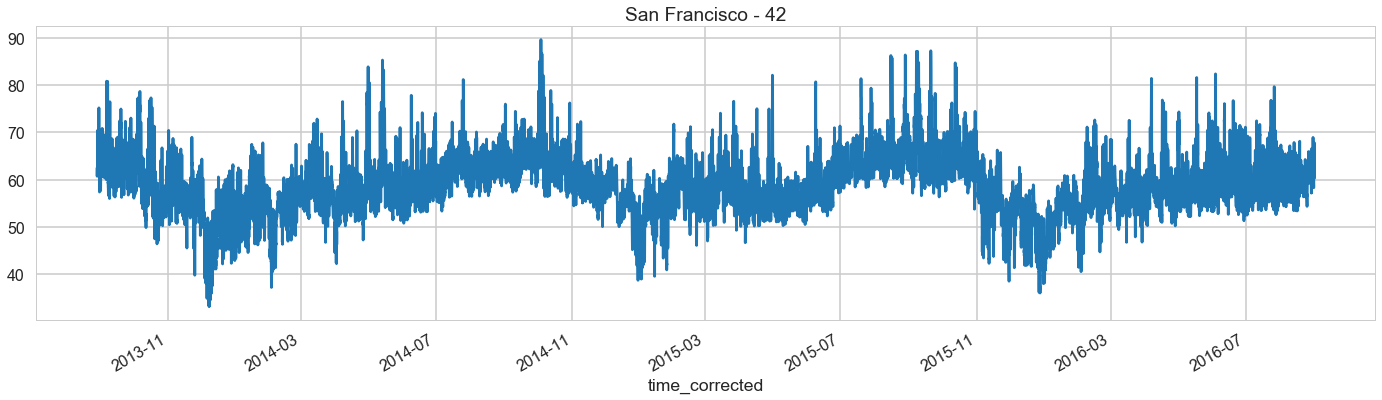

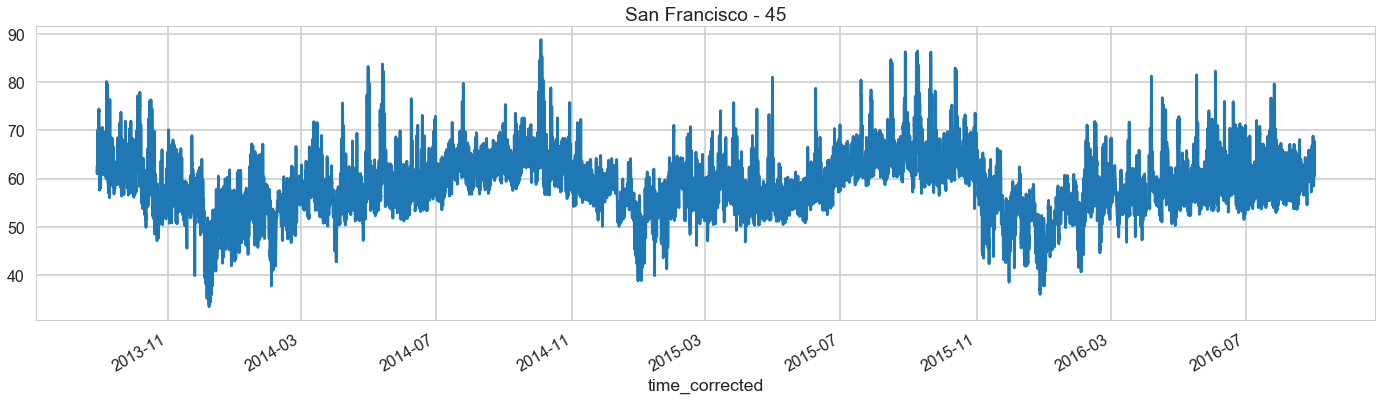

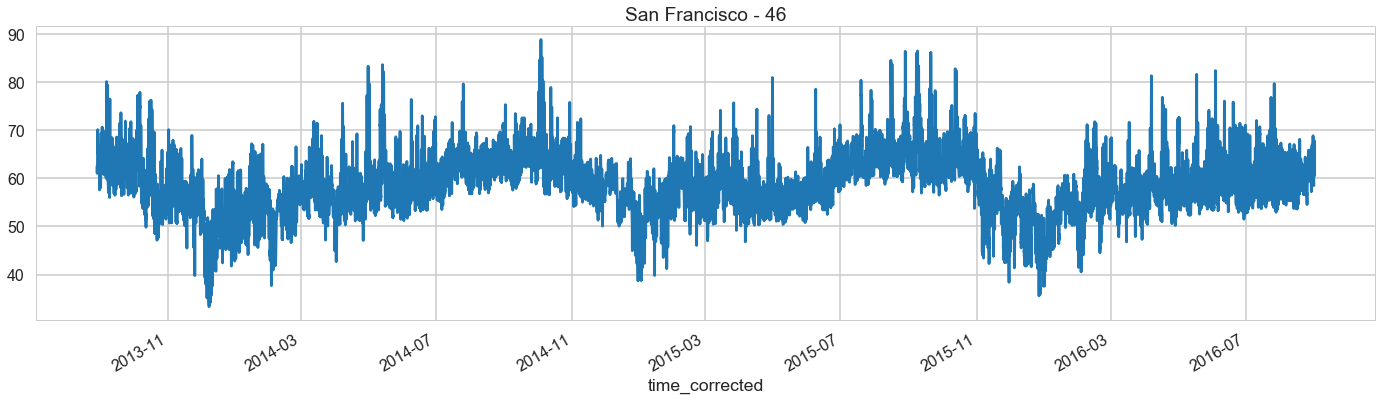

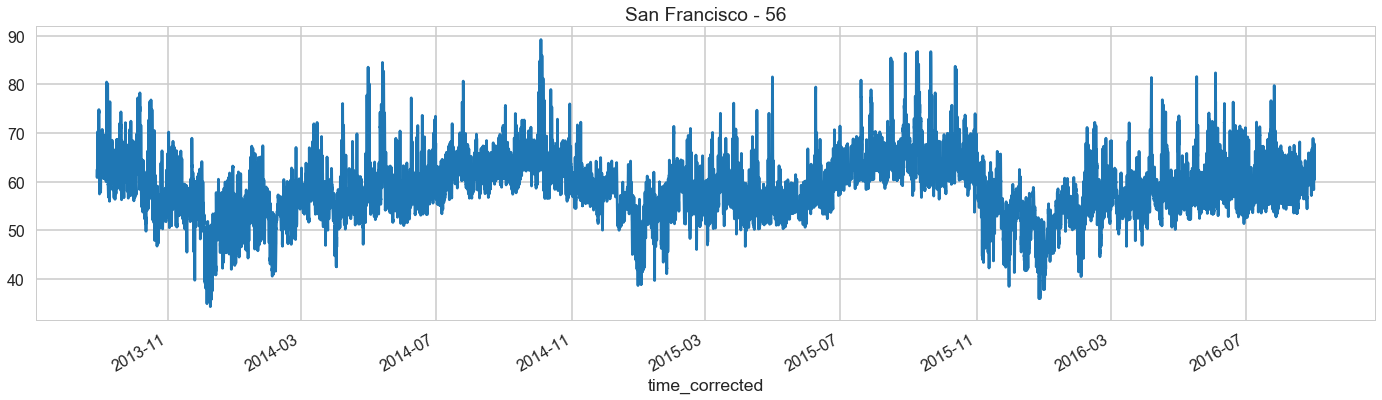

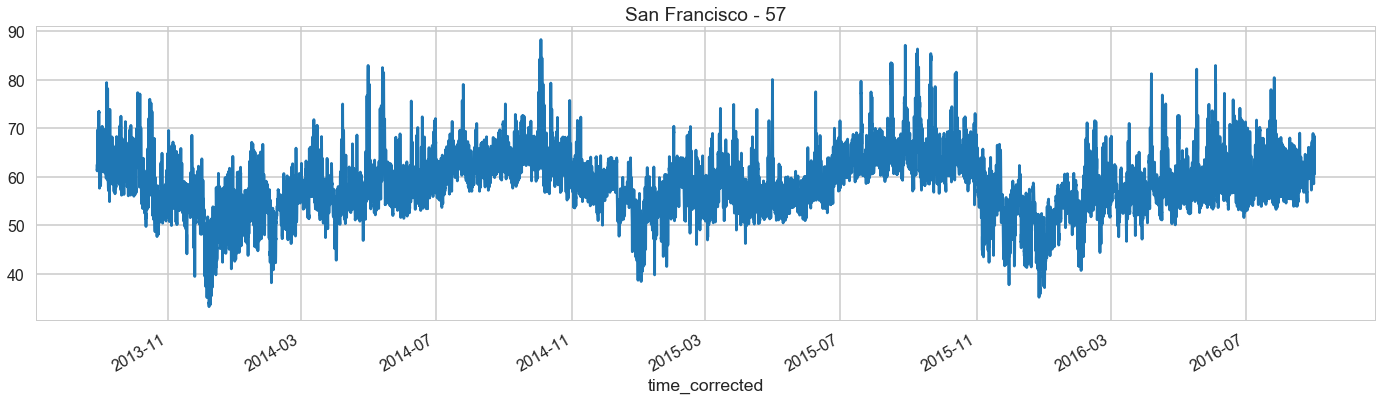

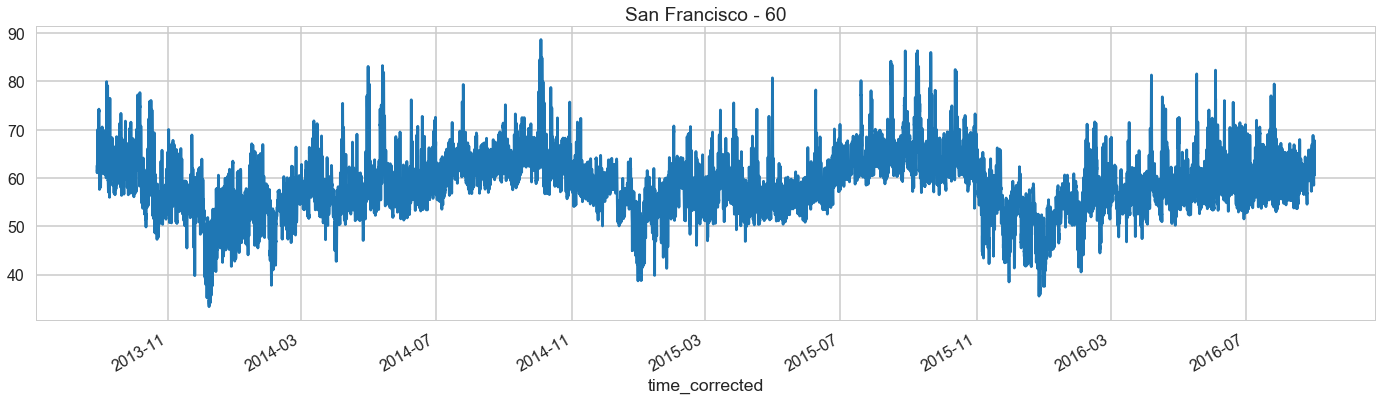

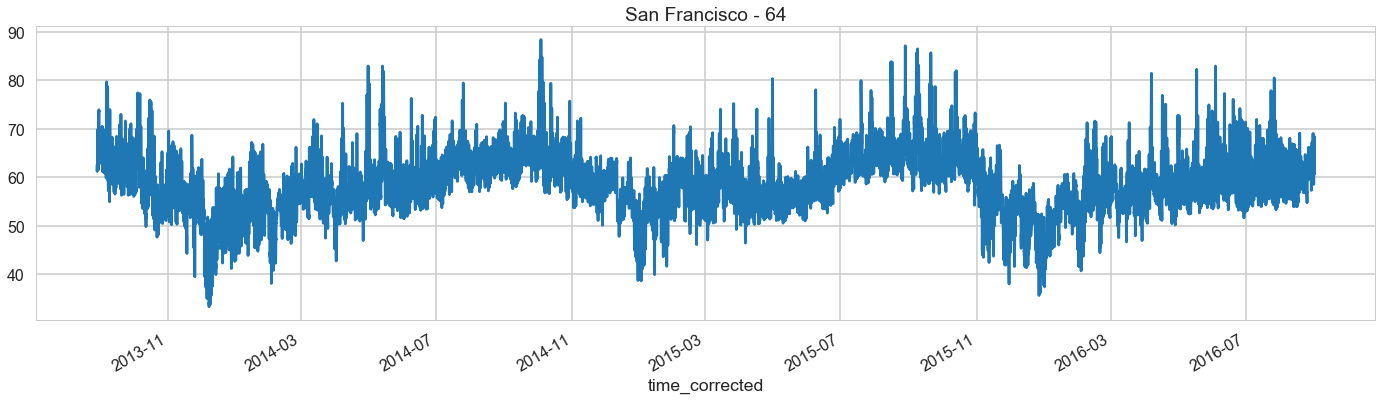

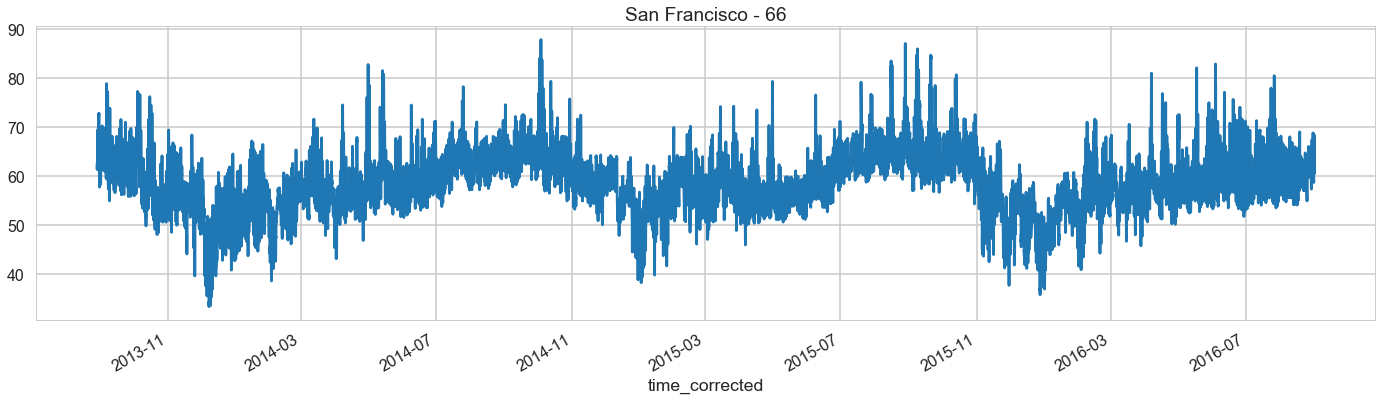

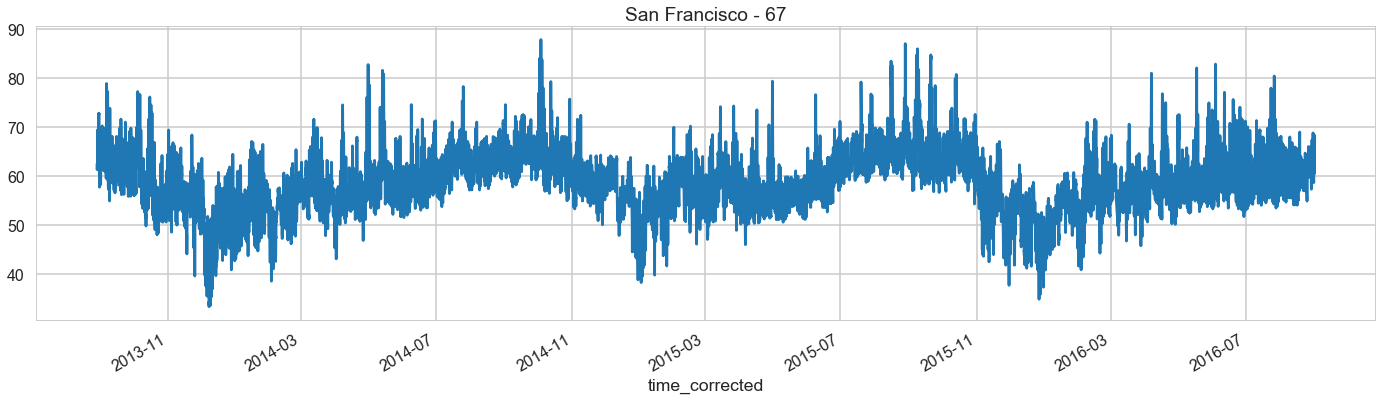

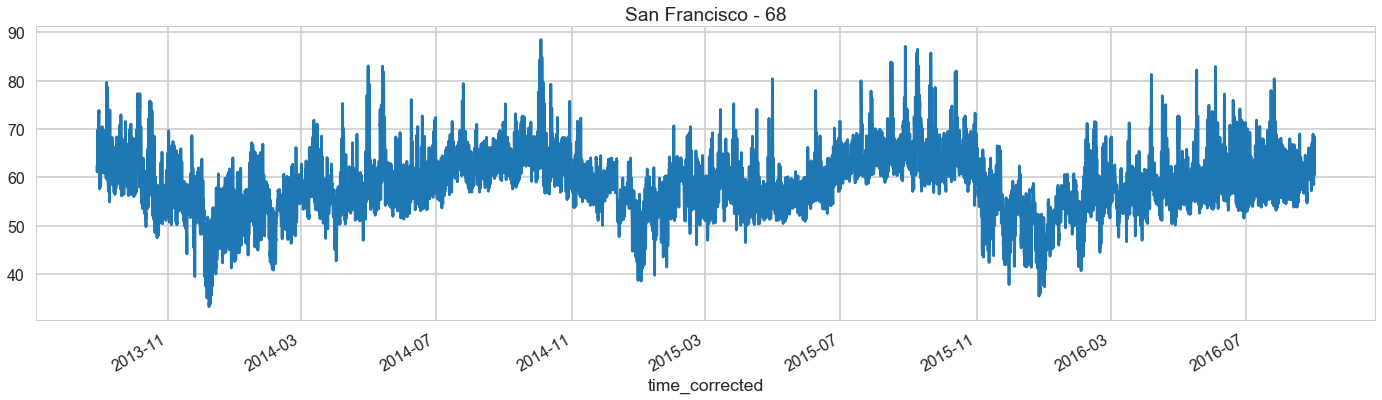

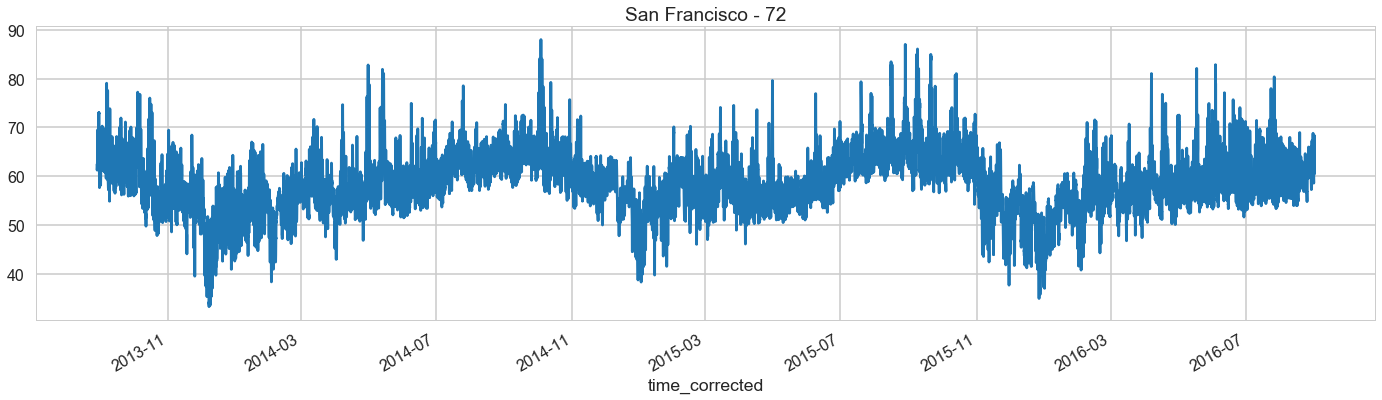

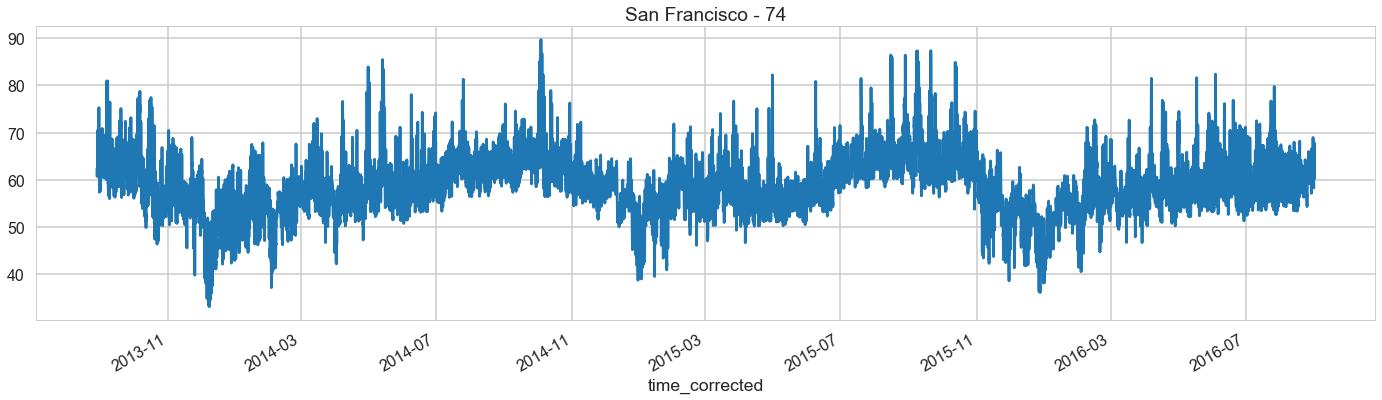

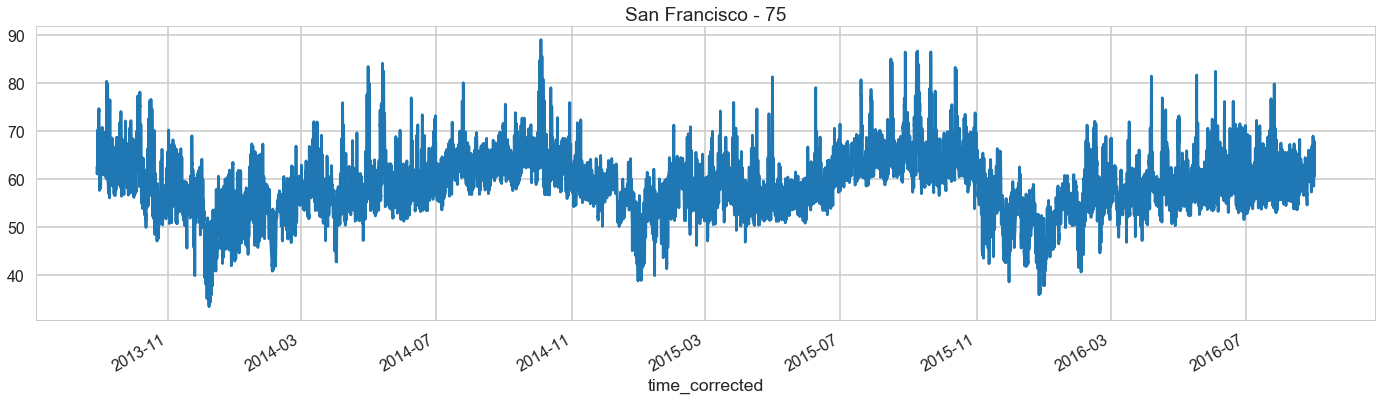

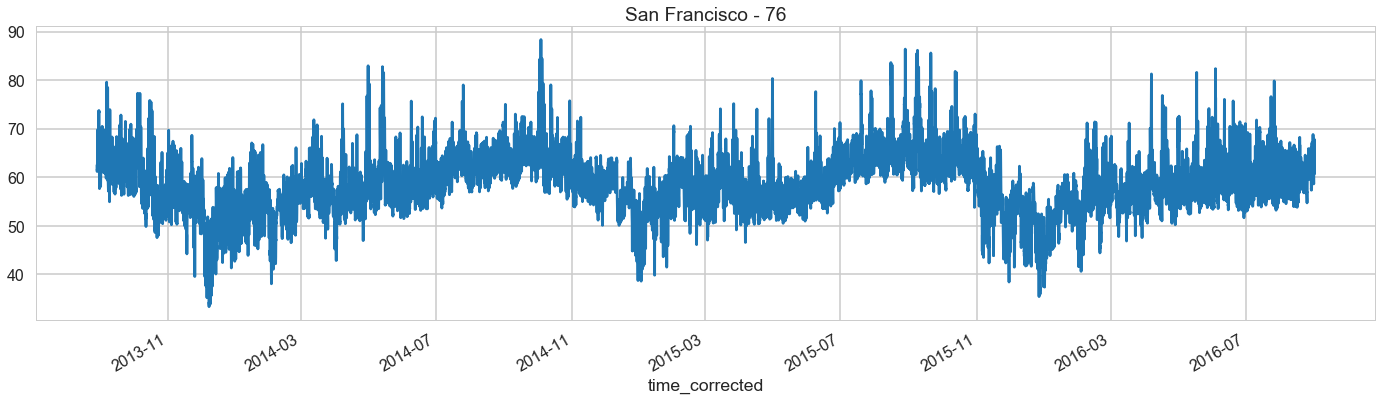

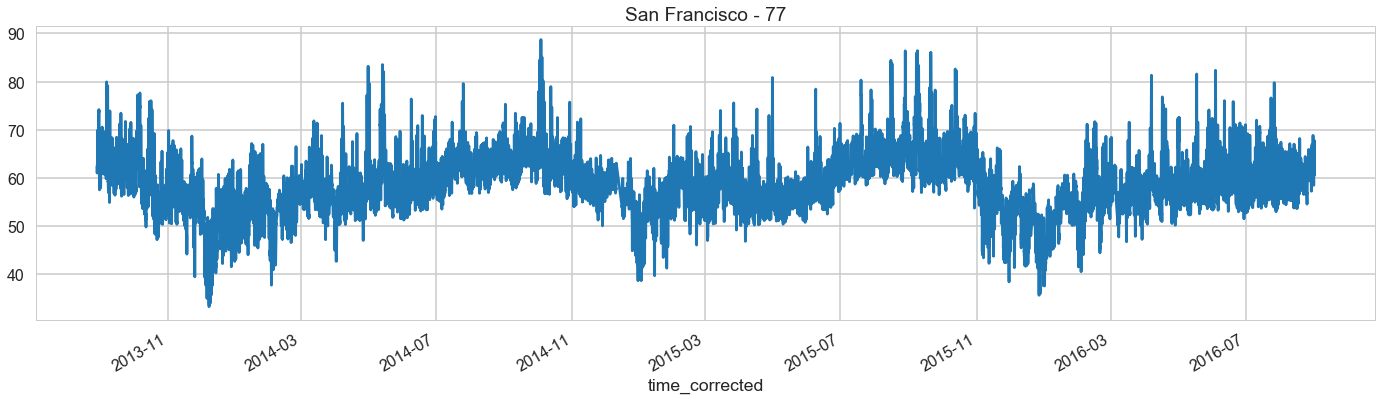

In [15]:
for sid in sorted(weather_merged.station_id.unique()):
    
    df = weather_merged[weather_merged.station_id == sid].copy()
    df.sort_values('time_corrected', inplace=True)
    df.set_index('time_corrected', inplace=True)
    
    df.apparentTemperature.plot(figsize=(24,6))
    title = '%s - %s' % (zip_to_landmark(df.zip_code.unique()), sid)
    plt.title(title)
    plt.show()
    

In [16]:
weather_merged['apparentTemperature'] = weather_merged['apparentTemperature'].astype('float')
weather_merged['cloudCover']          = weather_merged['cloudCover'].astype('float')
weather_merged['daily_icon']          = weather_merged['daily_icon'].astype('category')
weather_merged['dewPoint']            = weather_merged['dewPoint'].astype('float')
weather_merged['hourly_icon']         = weather_merged['hourly_icon'].astype('category')
weather_merged['humidity']            = weather_merged['humidity'].astype('float')
weather_merged['latitude']            = weather_merged['latitude'].astype('float')
weather_merged['longitude']           = weather_merged['longitude'].astype('float')
weather_merged['precipIntensity']     = weather_merged['precipIntensity'].astype('float')
weather_merged['precipProbability']   = weather_merged['precipProbability'].astype('float')
weather_merged['precipType']          = weather_merged['precipType'].astype('category')
weather_merged['pressure']            = weather_merged['pressure'].astype('float')
weather_merged['temperature']         = weather_merged['temperature'].astype('float')
weather_merged['time_corrected']      = pd.to_datetime(weather_merged['time_corrected'])
weather_merged['visibility']          = weather_merged['visibility'].astype('float')
weather_merged['windBearing']         = weather_merged['windBearing'].astype('float')
weather_merged['windSpeed']           = weather_merged['windSpeed'].astype('float')
weather_merged['station_id']          = weather_merged['station_id'].astype('int')
weather_merged['landmark']            = weather_merged['landmark'].astype('category')
weather_merged['zip_code']            = weather_merged['zip_code'].astype('int')

# Write to File

In [ ]:
weather_merged.to_csv('../clean_data/darksky/darksky_cleaned.csv')

In [17]:
def plot_category(cat):
    y_max = 0
    y_min = 0
    
    for l in pd.unique(weather_merged.landmark):
        df = weather_merged[weather_merged.landmark == l]

        df.set_index('time_corrected', inplace=True)

        df.groupby([df.index.hour]).median()[cat].plot(figsize=(24,6), label=l)
        df_max = df.groupby([df.index.hour]).median()[cat].max()
        if math.ceil(df_max) > y_max:
             y_max = math.ceil(df_max)
        
        df_min = df.groupby([df.index.hour]).median()[cat].min()
        if math.floor(df_min) < y_min:
             y_min = math.floor(df_min)
        
    plt.legend(loc='best', frameon=True)
    plt.title(cat)

    plt.xticks(sorted(pd.unique(weather_merged.time_corrected.dt.hour)))

    y_interval = (y_max-y_min)/10
    plt.yticks(np.arange(y_min, y_max+(3*y_interval), y_interval))

    plt.show()

In [18]:
plot_category('windSpeed')

In [19]:
plot_category('windBearing')

ZeroDivisionError: float division by zero

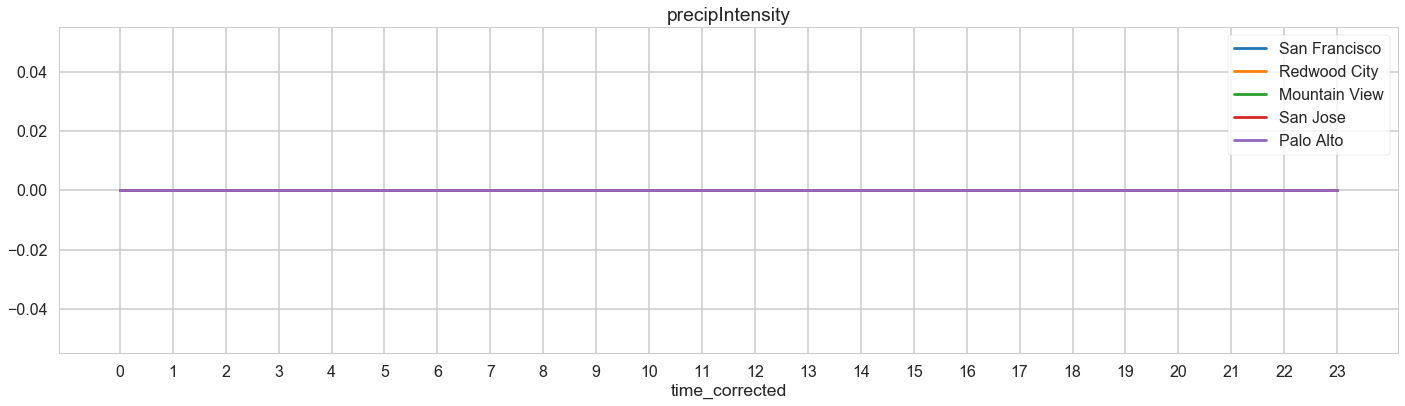

In [20]:
plot_category('precipIntensity')